# Neural Network from Scratch
## Table of Contents
> ### Introduction
> ### 1. Helper Functions
> ### 2. 2-Layer Network with Bias
> ### 3. Mini Batches

***

## Introduction

The goal of this notebook is to explore the problem of classifying handwritten digits using artificial neural networks (ANNs). The data set we will be using comes from The MNIST Database, which is a collection of 70,000 28 by 28 pixel images of handwritten digits. The 70,000 images are split into a set of 60,000 training images and 10,000 images to test various models on. 

We will build a two-layer neural network with sigmoid layers and bias from scratch. Neural networks can be very computationally intensive, so the last part of the notebook is devoted to improving the efficiency of the computations required to improve the network parameters (gradient descent).

***

## 1. Helper Functions

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from mnist import MNIST

In [2]:
mnist=MNIST('mnist/')

# import data
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

# rescale by dividing by the number of pixels in each image
X_test = np.array(test_images).T/784
y_test = np.array(test_labels)

print('training images: ',len(train_images))
print('testing images: ',len(test_images))

training images:  60000
testing images:  10000


Now, we'll define some helpful functions:

In [3]:
# prints handwritten digit
def show_num(X,k):
    plt.imshow(X[:,k].reshape((28,28)),cmap='Greys')
    plt.xticks([])
    plt.yticks([])

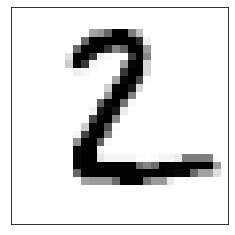

In [4]:
# for example:
show_num(X_test,1)

The following function gives us interesting information about the network. By plotting the rows of $W^T$ as images, we can see what the network is 'looking for' at each node.  

In [5]:
# displays the rows of WT as images
def show_nodes(WT,bias):
    k = WT.shape[0]
    plt.figure(figsize=(36,7))
    for j in range(k):
        plt.subplot(1,k,j+1)
        if bias=='Y':
            plt.imshow(WT[:,:-1][j].reshape((28,28)),cmap='seismic')
        else:
            plt.imshow(WT[j].reshape((28,28)),cmap='seismic')
        plt.xticks([])
        plt.yticks([])

## 2. 2-Layer Network with Bias

Here is the set up: in the diagram below, a $\large\circ$ represents an artificial neuron.
\begin{equation}
\large
\underbrace{\begin{array}{c}\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\end{array}}_{\text{Input Layer}}
\xrightarrow{\ W^T \ }
\underbrace{\begin{array}{c}\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\end{array}
\xrightarrow{\sigma}
\begin{array}{c}\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\end{array}}_{\text{First Sigmoidal Layer}}
\xrightarrow{\ V^T \ }
\underbrace{\begin{array}{c}\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\end{array}
\xrightarrow{\sigma}
\begin{array}{c}\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\\[-10pt]\circ\end{array}}_{\text{Second Sigmoidal Layer}}
\end{equation}

We feed in the images $X$ into the input layer and apply the transformation $W^T$ to take us into the first layer. We follow this with a coordinate-wise sigmoid function given by:
$$\sigma(x) = \frac{1}{1+e^{-x}}.$$
If we didn't apply this, then the composition $V^TW^T$ would just be another linear transformation, and we might as well only have one layer. We follow this through into the second layer via $V^T$ and apply the sigmoid again. From here, in order to compute the loss, we take the difference of the output with the one-hot encoded true classification. 

Our first order of business is to compute that gradient using back-propagation. For this, we will need the derivative of the sigmoid function, which is given by:
$$\frac{d}{dx}\sigma(x) = \frac{d}{dx}\frac{1}{1+e^{-x}} = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}}\cdot\frac{e^{-x}}{1+e^{-x}} = \sigma(x)\cdot\frac{1+e^{-x}-1}{1+e^{-x}} = \sigma(x)(1-\sigma(x)).$$ 

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def Dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

sigmoid(0),Dsigmoid(0)

(0.5, 0.25)

Here is another sigmoid function which is commonly used that my office mate mentioned:

In [7]:
# for experimentation
def ReLU(x):
    return np.maximum(x,np.zeros_like(x))

def DReLU(x):
    return np.minimum(ReLU(x),np.ones_like(x))

Now we need to discuss bias. Let $\vec{x}$ be an input vector. Generally, bias is a vector $\vec{b}$ that serves as a shift to the linear transformation $W^T\vec{x}$, giving us instead an affine transformation $W^T\vec{x}+\vec{b}$ from an input $\vec{x}$ into the next layer. Here, we will be slick and add the bias into the vectors $W^T$ and $V^T$, by attaching 'pseudo-pixels' to the input vectors:
\begin{equation}
\left(\begin{array}{cc}w_{00} & w_{01} & b_0 \\ w_{10} & w_{11} & b_1 \end{array}\right)\left(\begin{array}{c}x_1\\ x_2\\ 1 \end{array}\right) = \left(\begin{array}{c}w_{00}x_1+ w_{01}x_2+b_0 \\ w_{10}x_1+ w_{11}x_2+b_1\end{array}\right) = W^T\vec{x}+\vec{b}
\end{equation}
This way, gradient descent updates the bias for the first and second layer when it updates $W^T$ and $V^T$. So, we need a function that appends a row of ones to our inputs:

In [8]:
def add_row_ones(X):
    return np.append(X,np.ones(X.shape[1])).reshape(X.shape[0]+1,X.shape[1])

As for computing the gradient, it's somewhat messy, but one can get an idea for the relationships involved by looking at a toy case like all matrices being $2\times 2$. To summarize, the relationships we have are:
\begin{equation}
\displaystyle \frac{\partial L}{\partial W^T} = \frac{\partial L}{\partial Y_W}X^T,\quad \frac{\partial L}{\partial Y_W} = \frac{\partial L}{\partial \sigma(Y_W)}\cdot\sigma'(Y_W),\quad \frac{\partial L}{\partial\sigma(Y_W)} = V\frac{\partial L}{\partial Y_V},\quad \frac{\partial L}{\partial Y_V} = \frac{\partial L}{\partial\sigma(Y_V)}\cdot\sigma'(Y_V),\quad\text{and}\quad \frac{\partial L}{\partial\sigma(Y_V)} = 2(\sigma(Y_V)-T)
\end{equation}
where $Y_W = W^TX$, $Y_V = V^T\sigma(Y_W)$, $\sigma(Y_W)$ and $\sigma(Y_V)$ are the sigmoid applied entry-wise to $Y_W$ and $Y_V$ respectively, and $T$ is the matrix of true classes. This is encoded in the function below.

In [9]:
def loss(WT,VT,X,y):
    # add row of ones for bias
    X1 = add_row_ones(X)
    
    # go to next layer
    YW = np.dot(WT,X1)
    
    # apply sigmoid
    SW = sigmoid(YW)
    
    # append ones for second bias
    SW1 = add_row_ones(SW)
    
    # go to next layer
    YV = np.dot(VT,SW1)
    
    # apply sigmoid
    SV = sigmoid(YV)

    # get predictions
    y_pred = np.argmax(SV,axis=0)
    
    # compute difference of squares
    Z = np.zeros_like(SV)
    Z[ y,np.arange(SV.shape[1]) ] = 1
    G = (SV-Z)**2
    z = np.array([ G[:,i].sum() for i in range(G.shape[1]) ])
    
    # get loss
    L=z.sum()
    
    # back propogation
    dLdYV = 2*(SV-Z)*Dsigmoid(YV)
    dLdSW = np.dot(VT[:,:-1].T,dLdYV)
    dLdYW = dLdSW*Dsigmoid(YW)
    dLdWT = np.dot(dLdYW,X1.T)
    dLdVT = np.dot(dLdYV,SW1.T)
    
    return L, dLdWT, dLdVT, y_pred

Before moving on, let's make sure that we've computed the gradients correctly. To check, we will make use of the standard approximation of the derivative:

$$
    f'(x) \approx \frac{f(x+\delta)-f(x)}{\delta}
$$

for very small $\delta$.

In [10]:
k=2
delta = 1.0e-8

X = np.array([[1,2],[3,4]])
y = np.array([0,1])

WT = np.random.rand(k,X.shape[0]+1)
VT = np.random.rand(10,k+1)

LW0, dLdWT,foo1,foo2 = loss(WT,VT,X,y)
WT1 = WT
WT1[1,1] += delta
LW1,foo,foo1,foo2 = loss(WT1,VT,X,y)
approx = (LW1-LW0)/delta
print('Exact dWT: ',dLdWT[1,1])
print('Approx dWT: ',approx,'\n')

LV0, foo1, dLdVT, foo2 = loss(WT,VT,X,y)
VT1 = np.array(VT)
VT1[0,2] += delta
LV1,foo,foo1,foo2 = loss(WT,VT1,X,y)
approx = (LV1-LV0)/delta
print('Exact dVT: ',dLdVT[0,2])
print('Approx dVT: ',approx)

Exact dWT:  0.1794152827957977
Approx dWT:  0.17941523822173622 

Exact dVT:  0.18827383155582522
Approx dVT:  0.18827392977982527


Now, we define the gradient descent function.

In [11]:
def iterate_learning(WT,VT,X,y,learn_rate,iterations,M):
    L, gradLW, gradLV,y_pred = loss(WT,VT,X,y)
    y_new_pred = loss(WT,VT,X_test,y_test)[-1]
    acc = (y_new_pred==y_test).sum()*100/len(y_new_pred)
    
    print('Max Value of gradWT: ',gradLW.max())
    print('Max Value of gradVT: ',gradLV.max())
    print('Starting Loss: ',L,'Starting Accuracy: ',acc,'\n')

    for i in range(iterations):
        #step along -grad
        WT += -learn_rate*gradLW 
        VT += -learn_rate*gradLV
        L, gradLW, gradLV, y_pred = loss(WT,VT,X,y)

        y_new_pred = loss(WT,VT,X_test,y_test)[-1]
        acc = (y_new_pred==y_test).sum()*100/len(y_new_pred)
        if i%M==0: # only need to print every M
            print('Loss: ',L,'Accuracy: ',acc)

### First Run

Now, we are ready for the first run. The 2-layer case is a bit more computationally intensive, so we will restrict ourselves to only the first 5000 images to get a feel for what is going on. We have a choice on the number of artificial neurons for the first layer, while the second/output layer must have 10 since this is the number of classes. Below, I am initializing $W^T$ to be the first $k$ images of our inputs $X$ for the simple reason that it's the only option I've found that works; all other options give a gradient that either vanishes or starts identically 0, and so $W^T$ is not updated/improved.

Max Value of gradWT:  20.331742987052987
Max Value of gradVT:  111.91458299713307
Starting Loss:  44447.29700475641 Starting Accuracy:  8.92 

Loss:  43423.4981342212 Accuracy:  8.92
Loss:  14900.992801201537 Accuracy:  8.92
Loss:  8869.564813143632 Accuracy:  8.92
Loss:  4788.5012910935575 Accuracy:  9.39
Loss:  4786.106647894086 Accuracy:  10.27


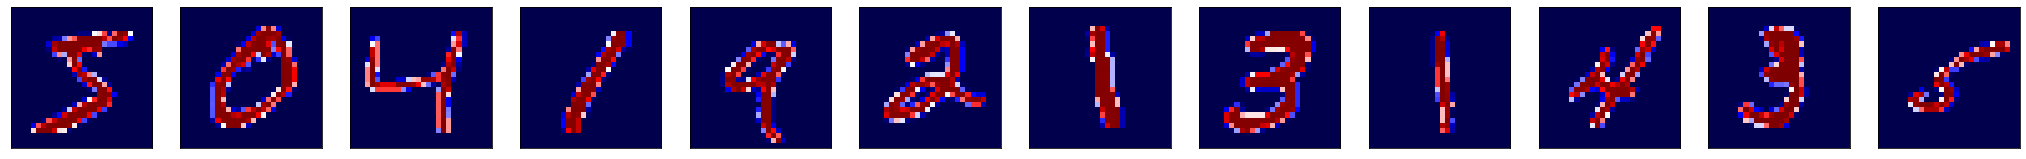

In [12]:
num_images=5000
k=12
X = np.array(train_images[:num_images]).T/784
y = np.array(train_labels[:num_images])

#WT = np.random.rand(k,X.shape[0]+1) #random
WT = add_row_ones(X)[:,:k].T # currently best option

VT = np.random.rand(10,k+1)
#VT = np.zeros((10,k+1))

show_nodes(WT,'Y')
iterate_learning(WT,VT,X,y,1e-3,25,5)

Clearly this isn't going to improve terribly fast, but we'll run gradient descent for a while and see where we end up:

In [13]:
iterate_learning(WT,VT,X,y,1e-3,100,10)

Max Value of gradWT:  4.492500474268541
Max Value of gradVT:  5.36098704188331
Starting Loss:  4783.957299362275 Starting Accuracy:  10.97 

Loss:  4783.37181887802 Accuracy:  11.14
Loss:  4775.885311569525 Accuracy:  12.67
Loss:  4762.7158425922225 Accuracy:  14.35
Loss:  4734.474142516454 Accuracy:  21.36
Loss:  4671.142648156719 Accuracy:  25.78
Loss:  4559.046026397925 Accuracy:  29.71
Loss:  4404.433565465166 Accuracy:  33.06
Loss:  4232.061989188676 Accuracy:  34.42
Loss:  4055.4767924511507 Accuracy:  35.21
Loss:  3900.5976794306252 Accuracy:  36.11


That is as far as I'm willing to go for now. We will see shortly how to make this process faster. The learning rate is extremely fickle: I've lost some fairly high accuracies due to being greedy and increasing the learning rate to 15e-3. Let's see what $W^T$ is searching for in the first layer: 

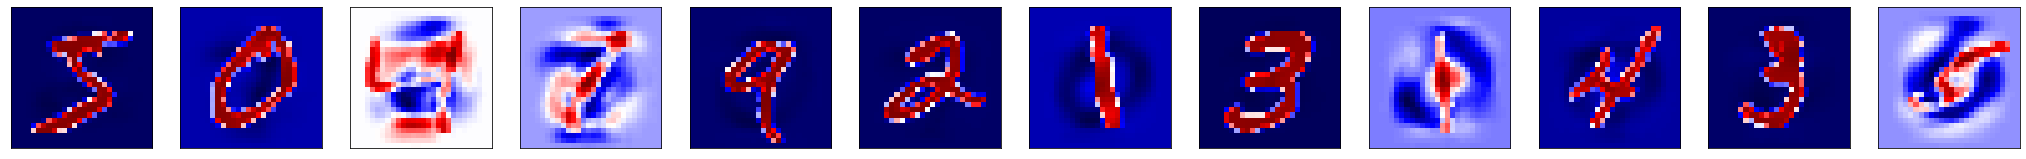

In [14]:
show_nodes(WT,'Y')

There are some fairly abstract patterns here, with several numbers sitting untouched. At this point, since we are only around 58% accuracy I'm hesitant to say that the rows of $W^T$ that haven't been altered much are extraneous. 

Now we are in a position where improving computation time is motivated, so we'll move on to mini-batches.

## 3. Mini-Batches

So far we have only trained on 5000 images, only $\approx$8% of the total training data available. Of course, it would be nice to use all of it at once, but this isn't computationally feasible. So, we employ the standard trick of breaking the computation up into several pieces which are easier to manage. For us, these smaller pieces are called 'mini-batches'.

Here is our procedure: a mini-batch will be a set containing $m$ images. We randomly shuffle the set of integers ```S = np.arange(60,000)``` and partition it into $60000/m$ smaller sets $S_i$, which will then be used to index the training data. If $F$ is the set of training data, then each $F[[S_i]]$ is a mini-batch.

In [15]:
# helpful global variables
F = np.array(train_images)
f = np.array(train_labels)

F.shape

(60000, 784)

The function below works exactly as described above.

In [16]:
def create_batches(mini_batch_size):
    # get number of partitions
    k = int(60000/mini_batch_size)

    # shuffle set of integers from 0 to 59,999
    l = np.random.choice(np.arange(60000),60000,replace=False)
    l = l.reshape((k,mini_batch_size))

    # get array of mini-batches
    B = np.array(
        [
            F[[ l[i] ]].T/784 for i in range(k)
        ]
    )
    
    # get true classes for each mini-batch
    y = np.array(
        [
            f[[ l[i] ]] for i in range(k)
        ]
    )
    return B, y

Let's look at a quick example. We choose a mini-batch size of 500 images, giving us a set of 60000/500 = 120 mini-batches. The following shows the 5th image and its true class of the 21st mini-batch:

/tmp/ipykernel_9789/282092606.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  F[[ l[i] ]].T/784 for i in range(k)
/tmp/ipykernel_9789/282092606.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[[ l[i] ]] for i in range(k)


(None, 1)

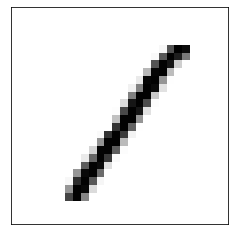

In [17]:
B, y = create_batches(500)
show_num(B[21],5),y[21][5]

Our gradient descent algorithm will look different now. The new procedure is to take a set of mini-batches, and use a random mini-batch for each iteration of gradient descent. This way, the parameters are 'seeing' all of the training data, but not all at once which is much less computationally intensive, and possibly more efficient. 

In [18]:
def mb_desc(WT,VT,X,y,learn_rate,iterations,M,batch,y_batch):
    # get first batch
    X = batch[0]
    y = y_batch[0]
    
    # generate loss, initial accuracy on test data
    L, gradLW, gradLV,y_pred = loss(WT,VT,X,y)
    y_new_pred = loss(WT,VT,X_test,y_test)[-1]
    acc = (y_new_pred==y_test).sum()*100/len(y_new_pred)
    
    # print initial info
    print('Max Value of gradWT: ',gradLW.max())
    print('Max Value of gradVT: ',gradLV.max())
    print('Starting Loss: ',L,'Starting Accuracy: ',acc,'\n')

    # iterate over batches, computing loss and accuracy
    for i in range(iterations):
        # select random batch and get images and labels
        j = np.random.randint(batch.shape[0])
        X = batch[j]
        y = y_batch[j]
        
        # compute loss, grad, step along -grad
        L, gradLW, gradLV, y_pred = loss(WT,VT,X,y)
        WT += -learn_rate*gradLW 
        VT += -learn_rate*gradLV
        
        # compute new accuracy and print occasionally 
        y_new_pred = loss(WT,VT,X_test,y_test)[-1]
        acc = (y_new_pred==y_test).sum()*100/len(y_new_pred)
        if i%M==0: # only need to print every M
            print('Loss: ',L,'Accuracy: ',acc)

Now, we create a set of mini-batches with each containing 3000 images. This gives us 20 sets of images to randomly iterate gradient descent over. Since we are updating the  loss for different batches of images each time, we will not always have a smaller loss or higher accuracy at each step. This will resemble more of a drunken walk down to the local minimum. 

The trick here is to choose a mini batch size that is small enough to make the gradient computation quick, but not so small that we have a garbage approximation to the data set. For this reason we will stick with a mini-batch size of 3000. We will also use 'archetypes' for the initial $W^T$.

/tmp/ipykernel_9789/282092606.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  F[[ l[i] ]].T/784 for i in range(k)
/tmp/ipykernel_9789/282092606.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[[ l[i] ]] for i in range(k)
/tmp/ipykernel_9789/324316169.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  WT

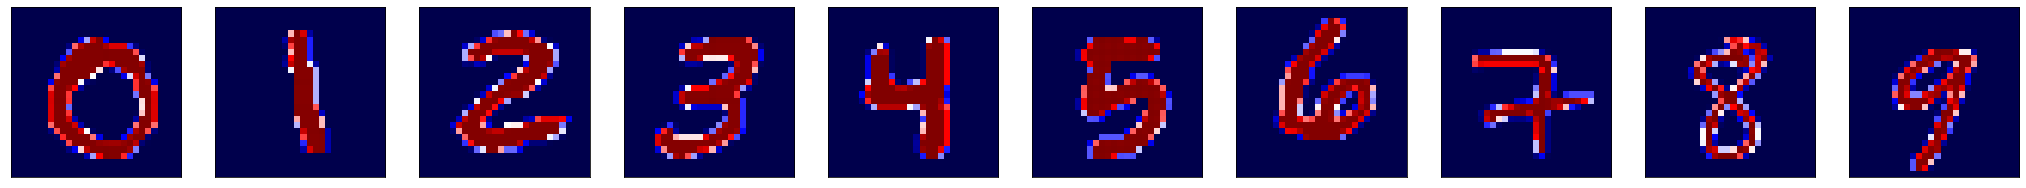

In [19]:
# get batches
B, y_B = create_batches(3000)

k=10 # number of nodes for first layer
X = B[0]
y = y_B[0]

archetype = np.array([56,6,25,7,58,244,221,38,46,45])
WT = add_row_ones(F[[archetype]].T).T/784 

VT = np.random.rand(10,k+1)
show_nodes(WT,'Y')

In [21]:
mb_desc(WT,VT,X,y,learn_rate=1e-3,iterations=700,M=1,batch=B,y_batch=y_B)

Max Value of gradWT:  7.351902876691205
Max Value of gradVT:  10.695292130812794
Starting Loss:  2729.0678681505224 Starting Accuracy:  18.33 

Loss:  2731.391316788926 Accuracy:  17.29
Loss:  2727.424695485354 Accuracy:  17.98
Loss:  2722.391871445039 Accuracy:  14.87
Loss:  2718.376858852339 Accuracy:  17.37
Loss:  2714.574123601261 Accuracy:  18.44
Loss:  2705.42821289559 Accuracy:  21.67
Loss:  2704.4974255261527 Accuracy:  27.64
Loss:  2700.440115575291 Accuracy:  22.72
Loss:  2700.1761937441543 Accuracy:  22.99
Loss:  2694.0526278146112 Accuracy:  27.08
Loss:  2695.4529739458085 Accuracy:  22.38
Loss:  2692.218391008723 Accuracy:  21.19
Loss:  2700.3029238703884 Accuracy:  25.74
Loss:  2693.0621990854565 Accuracy:  26.46
Loss:  2689.703940375929 Accuracy:  26.36
Loss:  2690.5938772675217 Accuracy:  27.15
Loss:  2685.448225270723 Accuracy:  26.49
Loss:  2679.5798393383725 Accuracy:  28.21
Loss:  2673.9740765192014 Accuracy:  26.69
Loss:  2681.0612997500184 Accuracy:  26.17
Loss:  

Loss:  1902.988330334673 Accuracy:  53.81
Loss:  1874.9192555096092 Accuracy:  53.09
Loss:  1891.9445226250025 Accuracy:  54.45
Loss:  1901.225190082365 Accuracy:  54.16
Loss:  1881.7022593317915 Accuracy:  55.24
Loss:  1873.8150943309531 Accuracy:  54.11
Loss:  1816.9852574340102 Accuracy:  54.7
Loss:  1834.8468848815503 Accuracy:  55.52
Loss:  1848.688107652864 Accuracy:  56.61
Loss:  1845.8165863098634 Accuracy:  56.23
Loss:  1793.7442362798624 Accuracy:  56.15
Loss:  1850.2532444944316 Accuracy:  56.71
Loss:  1829.930868854539 Accuracy:  58.0
Loss:  1818.2815216378235 Accuracy:  57.35
Loss:  1833.9564529231943 Accuracy:  57.79
Loss:  1812.9320433556068 Accuracy:  58.61
Loss:  1783.8465590998082 Accuracy:  59.36
Loss:  1817.1593591594192 Accuracy:  59.43
Loss:  1793.5329172334118 Accuracy:  59.07
Loss:  1792.1771880520268 Accuracy:  59.56
Loss:  1799.2495818121238 Accuracy:  60.3
Loss:  1785.2781433465866 Accuracy:  61.29
Loss:  1785.760640879867 Accuracy:  59.73
Loss:  1784.0221322

Loss:  1059.846595359378 Accuracy:  83.55
Loss:  1023.2652336155606 Accuracy:  84.03
Loss:  1006.2990261262623 Accuracy:  84.09
Loss:  989.3675075287329 Accuracy:  83.65
Loss:  1045.311405444801 Accuracy:  83.89
Loss:  1004.1142873527236 Accuracy:  83.4
Loss:  1027.95029502838 Accuracy:  83.91
Loss:  1043.5895425979288 Accuracy:  83.66
Loss:  987.3097381870095 Accuracy:  83.95
Loss:  1028.2065877663065 Accuracy:  83.64
Loss:  1028.1441825553975 Accuracy:  84.29
Loss:  1018.8972160974192 Accuracy:  84.28
Loss:  968.6774972368727 Accuracy:  83.9
Loss:  1030.5216790921602 Accuracy:  83.97
Loss:  1029.4300166444102 Accuracy:  84.37
Loss:  1010.3635769303726 Accuracy:  84.51
Loss:  1013.1495329661902 Accuracy:  84.52
Loss:  985.3848149732999 Accuracy:  84.59
Loss:  993.6149193796439 Accuracy:  84.35
Loss:  989.5070462809997 Accuracy:  84.34
Loss:  986.773943975383 Accuracy:  84.34
Loss:  984.1400688136187 Accuracy:  84.33
Loss:  997.1960600584605 Accuracy:  84.7
Loss:  971.7978020555643 Acc

Loss:  802.7506805174887 Accuracy:  86.85
Loss:  748.8019334651505 Accuracy:  86.74
Loss:  789.3382345146044 Accuracy:  86.94
Loss:  789.8154341945205 Accuracy:  86.83
Loss:  800.3599934879594 Accuracy:  86.94
Loss:  802.9247688163488 Accuracy:  86.99
Loss:  798.2687366427792 Accuracy:  87.0
Loss:  801.1950254434571 Accuracy:  86.98
Loss:  752.1917182762893 Accuracy:  87.01
Loss:  770.9304444727961 Accuracy:  87.03
Loss:  774.6351548919275 Accuracy:  86.95
Loss:  783.7227922696785 Accuracy:  86.93
Loss:  754.1513654660253 Accuracy:  86.9
Loss:  793.4511070001838 Accuracy:  86.98
Loss:  749.5261381618186 Accuracy:  86.99
Loss:  739.8639758214332 Accuracy:  86.81
Loss:  783.5145267269448 Accuracy:  86.93
Loss:  789.1593695049337 Accuracy:  87.03
Loss:  746.2718956462934 Accuracy:  86.99
Loss:  821.0619253909935 Accuracy:  86.96
Loss:  769.4278862010509 Accuracy:  87.04
Loss:  746.6902612748331 Accuracy:  86.98
Loss:  785.9504862297326 Accuracy:  87.04
Loss:  720.7495319140543 Accuracy:  

Let's take a moment to appreciate the efficiency here. Before, we needed over 2000 iterations of gradient descent with a learning rate of 1e-3 to get us to roughly 58% accuracy on test data. Here, 700 iterations of mini-batch descent took us all the way to over 85%! This is a massive improvement. Now let's see what $W^T$ is looking for in the first layer:

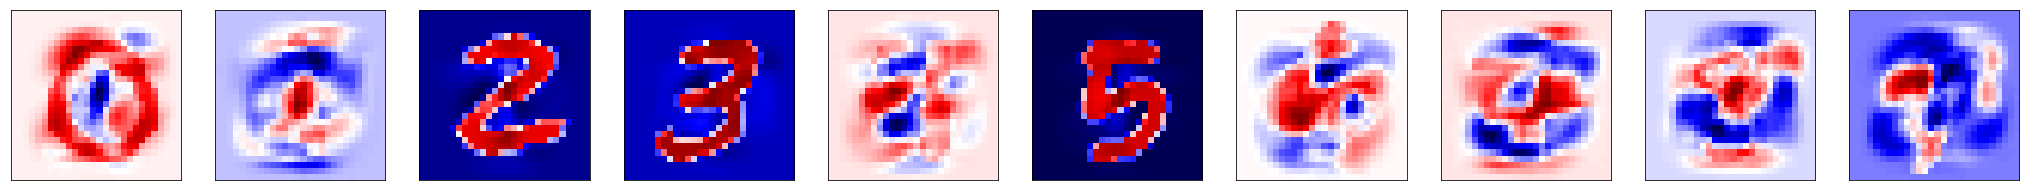

In [30]:
show_nodes(WT,'Y')

Out of 10 nodes in the first layer, 3 or 4 look untouched. The remainders are again fairly abstract. Let's do another set of 700 iterations and see how high we can get the accuracy:

In [31]:
mb_desc(WT,VT,X,y,learn_rate=1e-3,iterations=700,M=25,batch=B,y_batch=y_B)

Max Value of gradWT:  3.2494332921281908
Max Value of gradVT:  7.319328289440942
Starting Loss:  812.1196640767015 Starting Accuracy:  87.46 

Loss:  776.9903859458103 Accuracy:  87.45
Loss:  761.2593363230063 Accuracy:  87.81
Loss:  742.6355689717833 Accuracy:  87.95
Loss:  735.8207773808194 Accuracy:  88.07
Loss:  730.1540319442444 Accuracy:  88.25
Loss:  688.5319735942387 Accuracy:  88.23
Loss:  702.1545171414506 Accuracy:  88.47
Loss:  687.483733852233 Accuracy:  88.63
Loss:  662.3063235057256 Accuracy:  88.82
Loss:  653.5659170121797 Accuracy:  88.8
Loss:  661.8934442427512 Accuracy:  89.02
Loss:  619.4121144109268 Accuracy:  89.05
Loss:  626.544356273751 Accuracy:  89.18
Loss:  572.5166154977564 Accuracy:  89.29
Loss:  598.747483588141 Accuracy:  89.38
Loss:  602.6072739744652 Accuracy:  89.4
Loss:  575.2856576242941 Accuracy:  89.49
Loss:  627.4243978752546 Accuracy:  89.56
Loss:  583.5716833869712 Accuracy:  89.69
Loss:  600.677076528041 Accuracy:  89.63
Loss:  568.557638002672

So we are pretty close to 90% accuracy which is pretty good. Let's check for any changes in the nodes of the first layer:

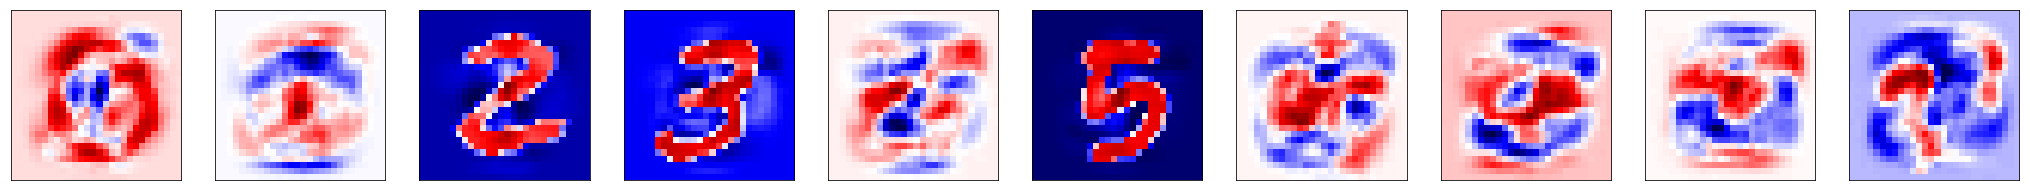

In [32]:
show_nodes(WT,'Y')

About the same. From here, I ran this one more time with a much larger iteration size, and the accuracy hovered around 90.75%. So for this particular initialized $W^T$ and $V^T$, the best we can do is roughly 91%. This is much more abstract than what we saw with the single-layer previously. Any improvement in accuracy after this is painfully slow, so I'll stop it here since 92% is pretty good!